In [1]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from astropy.io import fits
from scipy import ndimage
from matplotlib.colors import LogNorm

In [6]:
import os
datadir = '/home/jhl/data/charis'
fp = os.path.join(datadir, 'CRSA00008189.fits')
calibdir = '/home/jhl/data/charis/cal/'

from extractcube import getcube
cube = getcube(filename=fp, read_idx=[2, None],
               calibdir=calibdir, R=30, method='lstsq')

main - INFO - Getting reads from /home/jhl/data/charis/CRSA00008189.fits
main - INFO - Subtracting mean from all reference pixels


In [8]:
cube.data.shape

(22, 201, 201)

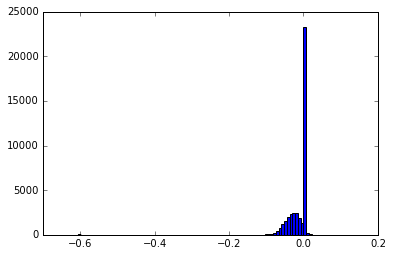

In [38]:
f = pl.hist(cube.data[0].flatten(), bins=100)

In [ ]:
vmin, vmax = -0.1, 0.05

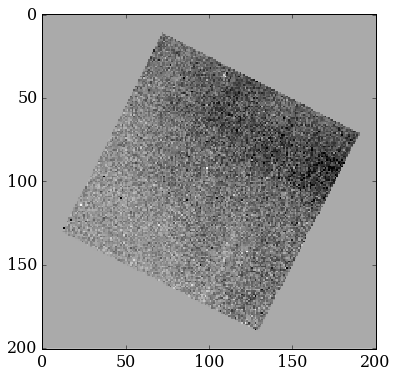

In [117]:
from ipywidgets import IntSlider, interact

slider = IntSlider(min=0, max=cube.data.shape[0]-1, value=0)
@interact(i=slider)
def explore_cube(i):
    pl.figure(figsize=(6,6))
#     pl.imshow(cube.data[i], interpolation='none', cmap=pl.cm.gray)
#     pl.imshow(cube.data[i], interpolation='none', cmap=pl.cm.gray, norm=LogNorm())
    pl.imshow(cube.data[i], interpolation='none', cmap=pl.cm.gray, vmin=vmin, vmax=vmax)

now call subroutines of getcube directly...
--

In [48]:
import utr

inImage = utr.utr(filename=fp, read_idx=[2,None], biassub='all')
inImage.data -= fits.open(os.path.join(calibdir, 'background.fits'))[0].data
inImage.ivar *= fits.open(os.path.join(calibdir, 'mask.fits'))[0].data

main - INFO - Getting reads from /home/jhl/data/charis/CRSA00008189.fits
main - INFO - Subtracting mean from all reference pixels


In [50]:
R = 30

psflets = fits.open(os.path.join(calibdir, 'polychromeR{}.fits'.format(R)))[0].data
keyfile = fits.open(os.path.join(calibdir, 'polychromekeyR{}.fits'.format(R)))
lam_midpts = keyfile[0].data
x = keyfile[1].data
y = keyfile[2].data
good = keyfile[3].data

import primitives
datacube = primitives.fit_spectra(inImage, psflets, lam_midpts, x, y, good, header=inImage.header)

In [53]:
(datacube.data == cube.data).all()

True

agrees with getcube output. now examine the inputs to fit_spectra
--

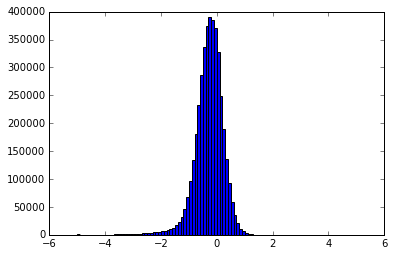

In [58]:
f = pl.hist(inImage.data.flatten(), bins=100, range=(-5,5))

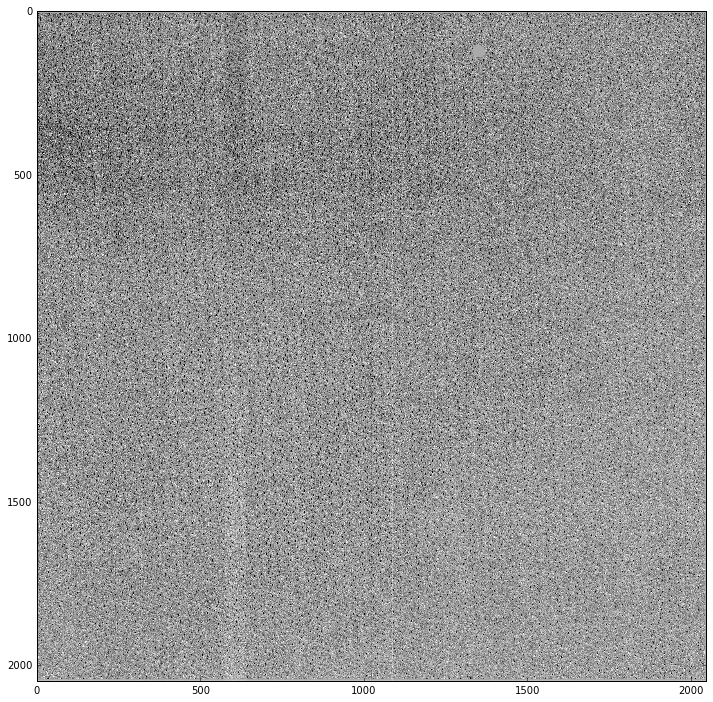

In [64]:
pl.figure(figsize=(12, 12))
pl.imshow(inImage.data, interpolation='none', cmap=pl.cm.gray, vmin=-2, vmax=1)

^ input image. doesn't look like what I expected
--

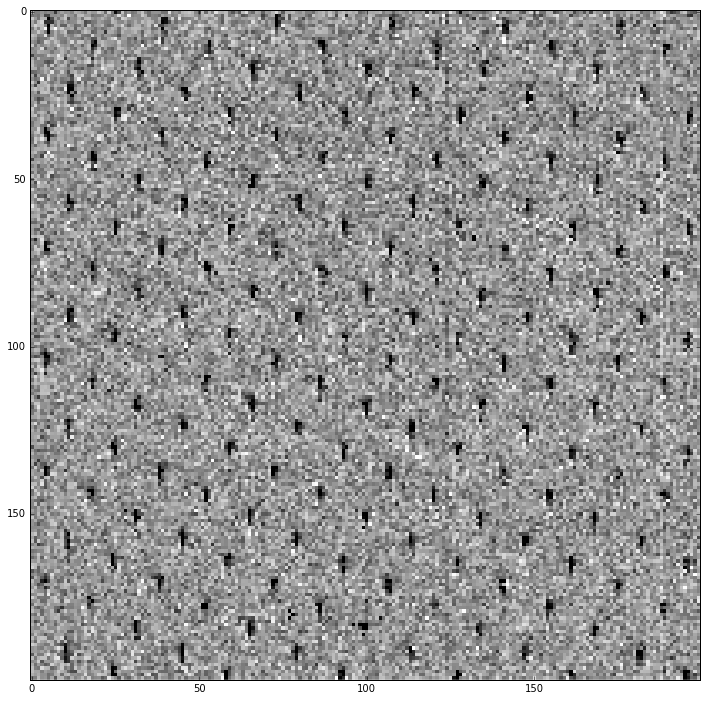

In [65]:
pl.figure(figsize=(12, 12))
pl.imshow(inImage.data[900:1100,900:1100], interpolation='none', cmap=pl.cm.gray, vmin=-2, vmax=1)

input image zoomed ^
--

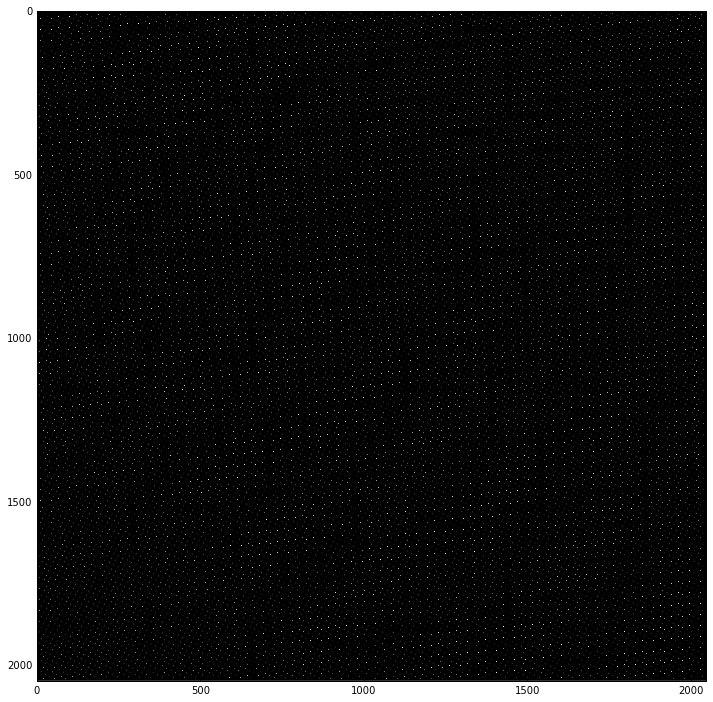

In [67]:
pl.figure(figsize=(12, 12))
pl.imshow(psflets[0], interpolation='none', cmap=pl.cm.gray)

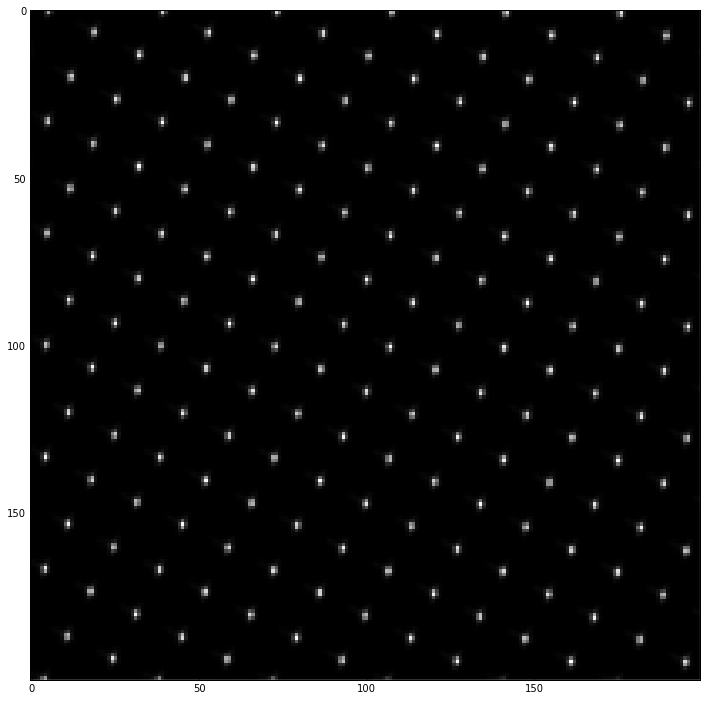

In [68]:
pl.figure(figsize=(12, 12))
pl.imshow(psflets[0][900:1100,900:1100], interpolation='none', cmap=pl.cm.gray)

^ the monochromatic spots for the 1st extracted wavelength
--

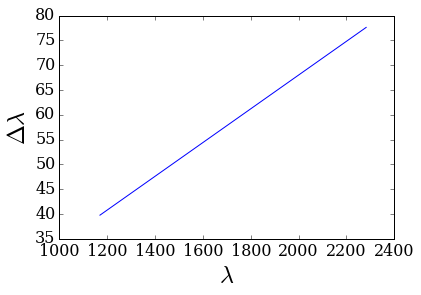

In [82]:
pl.figure(figsize=(6,4))
pl.rc('font', family='serif', size=16)
pl.plot(lam_midpts[:-1], np.diff(lam_midpts))
pl.xlabel('$\lambda$', fontsize=24)
pl.ylabel('$\Delta\lambda$', fontsize=24)

^ extracted wavelengths: difference between wavelengths is linear in wavelength
--

/home/jhl/miniconda2/envs/py2k/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


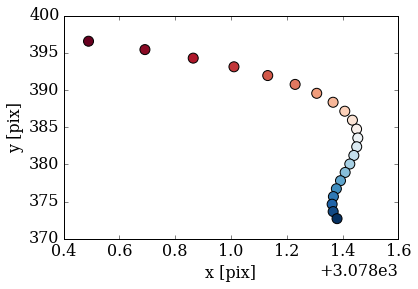

In [104]:
i,j = 0,0
# pl.plot(*zip(*[(x[k][i,j], y[k][i,j]) for k in range(x.shape[0])]), marker='o')
colors = [pl.cm.RdBu(i) for i in np.linspace(0,1,x.shape[0])]
pl.scatter(*zip(*[(x[k][i,j], y[k][i,j]) for k in range(x.shape[0])]), c=colors, s=100)
pl.xlabel('x [pix]')
pl.ylabel('y [pix]')

^ detector location of 1st spot as a function of wavelength
--

In [105]:
type(good)

numpy.ndarray

In [106]:
good.shape

(22, 201, 201)

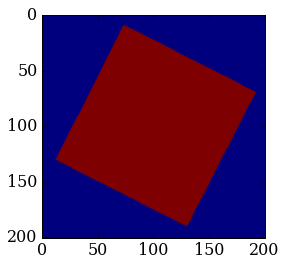

In [107]:
pl.imshow(good[0])

^ boolean array indicating if each spot lies on detector
--

In [108]:
inImage.header

OrderedDict([('biassub',
              ('all', 'Reference pixels used to correct ref voltage')),
             ('firstrd', (2, 'First HDU of original file used')),
             ('lastrd', (203, 'Last HDU of original file used')),
             ('origname', ('00008189', 'Original file ID number')),
             ('cubemode', ('leastsq', 'Method used to extract data cube')),
             ('lam_min',
              (1169.3903578602401,
               'Minimum (central) wavelength of extracted cube')),
             ('lam_max',
              (2360.2041708726515,
               'Maximum (central) wavelength of extracted cube')),
             ('dloglam',
              (0.033441217953578559,
               'Log spacing of extracted wavelength bins')),
             ('nlam', (22, 'Number of extracted wavelengths'))])

header of input image ^
--

now call subroutines of fit_spectra...
--

In [109]:
# fit_spectra inputs: inImage, psflets, lam_midpts, x, y, good, header=inImage.header
# inImage is the raw data
# psflets comes from polychromeR30.fits (produced by locatePSFlets)
# lam_midpts, x, y, good come from polychromekeyR30.fits (produced by locatePSFlets)

In [113]:
from primitives.fit_psflets import _get_cutout, _fit_cutout
import copy

im = inImage

###################################################################
# Fit the spectrum by minimizing chi squared
###################################################################

coefs = np.zeros(tuple([len(x)] + list(x[0].shape)))
resid = copy.deepcopy(im)

x = np.asarray(x)
y = np.asarray(y)

for i in range(x[0].shape[0]):

    for j in range(x[0].shape[1]):
        
        # check if spot is on detector
        if good[0][i, j] and good[-1][i, j]:
            subim, psflet_subarr, bounds = _get_cutout(im, x[:, i, j] + 0.5,
                                                       y[:, i, j], psflets)
            coefs[:, i, j] = _fit_cutout(subim, psflet_subarr, bounds,
                                         x=x[:, i, j], y=y[:, i, j],
                                         mode='lstsq')

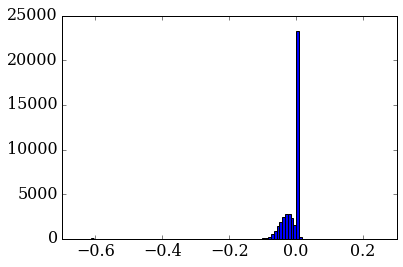

In [122]:
f = pl.hist(coefs[0].flatten(), bins=100)

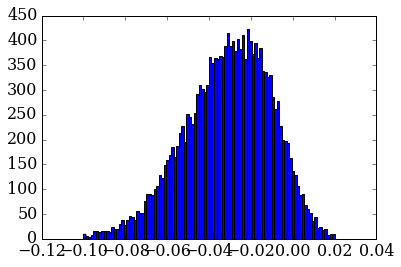

In [126]:
data = coefs[0].flatten()
f = pl.hist(data[data!=0], bins=100, range=(-0.1,0.02))

^ distribution of coefficient values for 1st wavelength
--

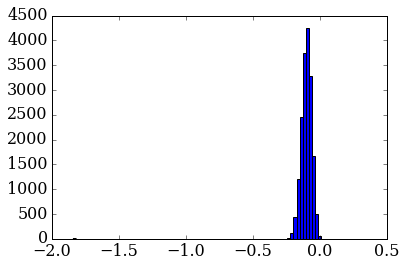

In [129]:
data = coefs[-1].flatten()
f = pl.hist(data[data!=0], bins=100)

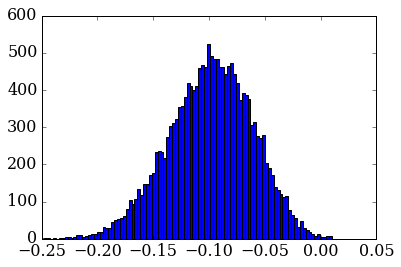

In [130]:
f = pl.hist(data[data!=0], bins=100, range=(-0.25,0.01))

^ distribution of coefficient values for last wavelength
--

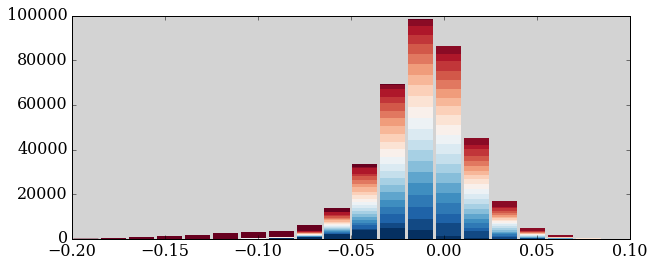

In [160]:
data = [i.flatten() for i in coefs]
pl.figure(figsize=(10,4))
pl.subplot(axisbg='lightgray')
colors = [pl.cm.RdBu_r(i) for i in np.linspace(0,1,coefs.shape[0])]
f = pl.hist([i[i!=0] for i in data], bins=20, color=colors, range=(-0.2,0.1), stacked=True, lw=0, rwidth=0.9)

coefficient values for all wavelengths, blue corresponds to coefs[0], red to coefs[-1]
--

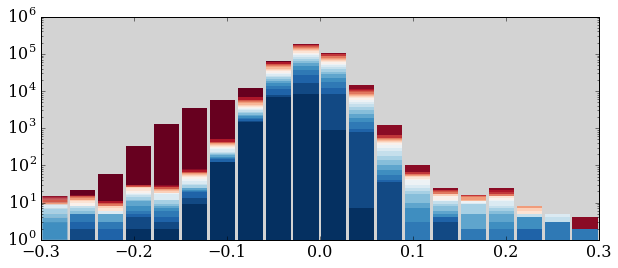

In [178]:
data = [i.flatten() for i in coefs]
pl.figure(figsize=(10,4))
pl.subplot(axisbg='lightgray')
colors = [pl.cm.RdBu_r(i) for i in np.linspace(0,1,coefs.shape[0])]
f = pl.hist([i[i!=0] for i in data], bins=20, color=colors, range=(-0.3,0.3), stacked=True, log=True, lw=0, rwidth=0.9)

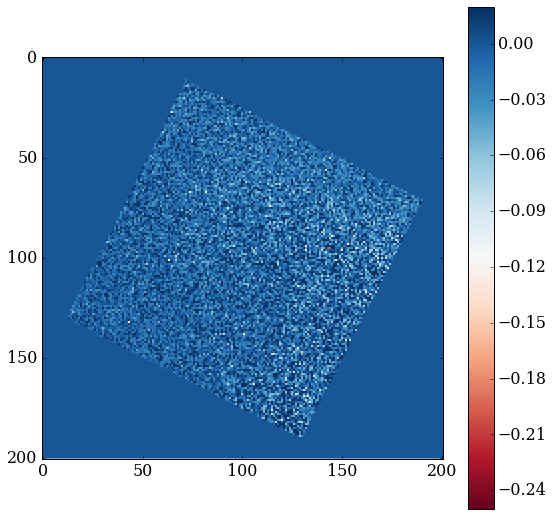

In [162]:
vmin, vmax = -0.25, 0.02
slider = IntSlider(min=0, max=coefs.shape[0]-1, value=0)
@interact(i=slider)
def explore_cube(i):
    pl.figure(figsize=(9,9))
#     pl.imshow(coefs[i], interpolation='none', cmap=pl.cm.gist_earth, norm=LogNorm())
    pl.imshow(coefs[i], interpolation='none', cmap=pl.cm.RdBu, vmin=vmin, vmax=vmax)
    pl.colorbar()

^ coefs by position on detector as a function of wavelength
--

In [163]:
from primitives.fit_psflets import _tag_psflets

###################################################################
# Subtract the best fit spectrum to include crosstalk
# Run the above routine again to get the perturbations to the
# intial guesses of the coefficients.
###################################################################

for i in range(len(psflets)):
    psflet_indx = _tag_psflets(psflets[i].shape, x[i], y[i], good[i])
    coefs_flat = np.reshape(coefs[i], -1)
    resid.data -= psflets[i]*coefs_flat[psflet_indx]

for i in range(x[0].shape[0]):
    for j in range(x[0].shape[1]):
        if good[0][i, j] and good[-1][i, j]:
            subim, psflet_subarr, bounds = _get_cutout(resid, x[:, i, j] + 0.5,
                                                       y[:, i, j], psflets)
            coefs[:, i, j] -= _fit_cutout(subim, psflet_subarr, bounds,
                                         x=x[:, i, j], y=y[:, i, j],
                                         mode='lstsq')

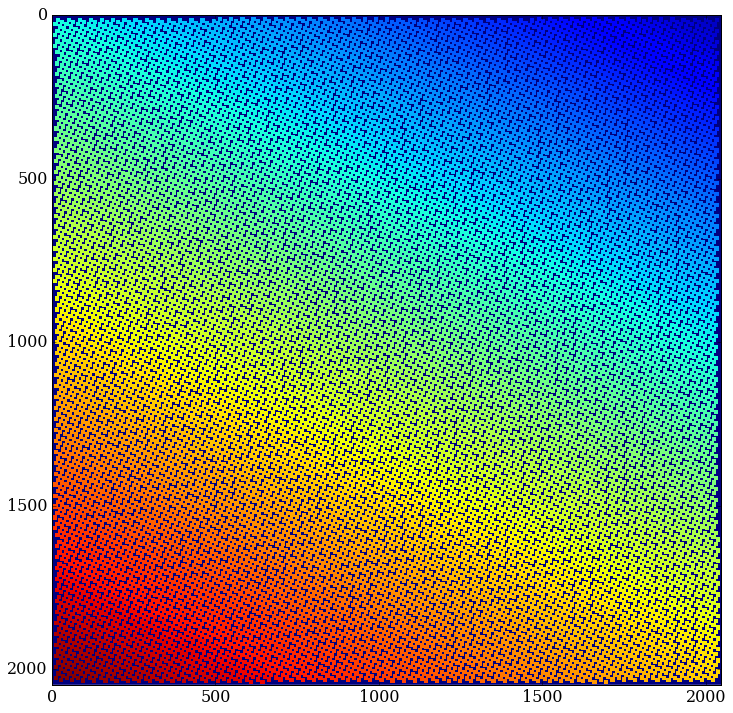

In [169]:
pl.figure(figsize=(12,12))
pl.imshow(psflet_indx, interpolation='none')

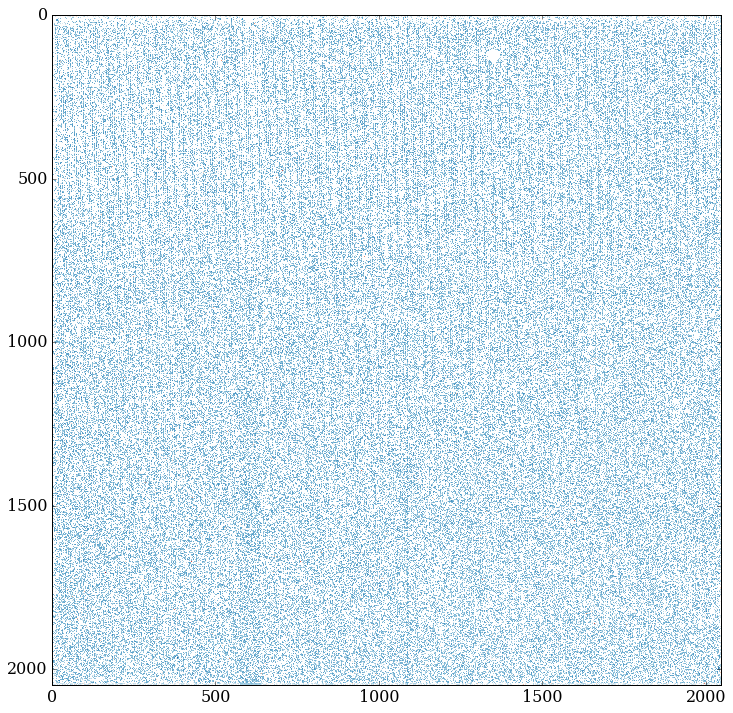

In [177]:
pl.figure(figsize=(12,12))
pl.imshow(resid.data, interpolation='none', cmap=pl.cm.RdBu, norm=LogNorm())